## Loading libraries and defining some functions

In [1]:
import glob, serial, time, math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from skimage.transform import iradon
from IPython.display import display
import random

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler

In [3]:
ports = glob.glob('/dev/tty[A-Za-z]*') # Modify if on a platform other than Linux
ports[0]

'/dev/ttyACM0'

In [6]:
ser = serial.Serial(ports[0], 115200)

In [7]:
ds = {0:b'i',
     7:b'j',
     3:b'k',
     4:b'l',
     2:b'm',
     5:b'n',
     6:b'o',
     1:b'p'}

es = {0:b'a',
     7:b'b',
     1:b'c',
     6:b'd',
     2:b'e',
     4:b'f',
     3:b'g',
     5:b'h'}

def read_d(d):
    ser.write(ds[d])
    while ser.in_waiting < 1:
        pass # wait for a response
    return ser.read_all()

def set_l(l):
    ser.write(es[l])
    while ser.in_waiting < 1:
        pass # wait for a response
    return ser.read_all()

def loff():
    ser.write(b'A')
    while ser.in_waiting < 1:
        pass # wait for a response
    return ser.read_all()

def read_all():
    a = []
    # Take a base set of readings
    loff()
    for d in range(8):
        a.append(int(read_d(d).strip()))
    for l in range(8):
        loff()
        set_l(l)
        for d in range(8):
            a.append(int(read_d(d).strip()))
        loff()
    return a

## Take a set of readings

In [94]:
base = read_all()[8:]
np.asarray(base).reshape(8, 8)

array([[580, 581, 582, 538, 320, 551, 534, 562],
       [604, 607, 590, 596, 545, 569, 571, 601],
       [611, 589, 601, 588, 588, 543, 439, 597],
       [574, 605, 592, 568, 575, 558, 499, 320],
       [393, 583, 579, 582, 579, 558, 541, 546],
       [545, 456, 585, 578, 572, 557, 553, 606],
       [595, 534, 378, 569, 583, 555, 530, 566],
       [593, 589, 575, 371, 580, 556, 543, 578]])

In [95]:
# Import required libraries
from image_util import *
import skimage.filters
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
import pandas as pd
from IPython.display import Image
from scipy.interpolate import interp1d
import astra

%matplotlib inline

def r8_to_sino(readings):
    sino = []
    for e in range(8):
        start = e*8 + (e+2)%8
        end = e*8 + (e+6)%8
        if end-start == 4:
            sino.append(readings[start : end])
        else:
            r = readings[start : (e+1)*8]
            for p in readings[e*8 : end]:
                r.append(p)
            sino.append(r)
    return np.asarray(sino)


In [96]:
nviews = 8
ndetectors = 4
nvdetectors = 4

IMSIZE = 50
R = IMSIZE/2
D = IMSIZE/2

# Transforming from a round fan-beam to a fan-flat projection (See diagram)
beta = np.linspace(0, math.pi, ndetectors)
alpha = np.asarray([R*math.sin(b-math.pi/2)/(R**2 + D**2)**0.5 for b in beta])
tau = np.asarray([(R+D)*math.tan(a) for a in alpha])

tau_new = np.linspace(-(max(tau)/2), 1.3*max(tau)/2, nvdetectors)

vol_geom = astra.create_vol_geom(IMSIZE, IMSIZE)
angles = np.linspace(0,2*math.pi,nviews);
d_size = (tau[-1]-tau[0])/nvdetectors
proj_geom= astra.create_proj_geom('fanflat', d_size, nvdetectors, angles, D, R);
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 17.8 s, sys: 10.9 s, total: 28.6 s
Wall time: 16.1 s


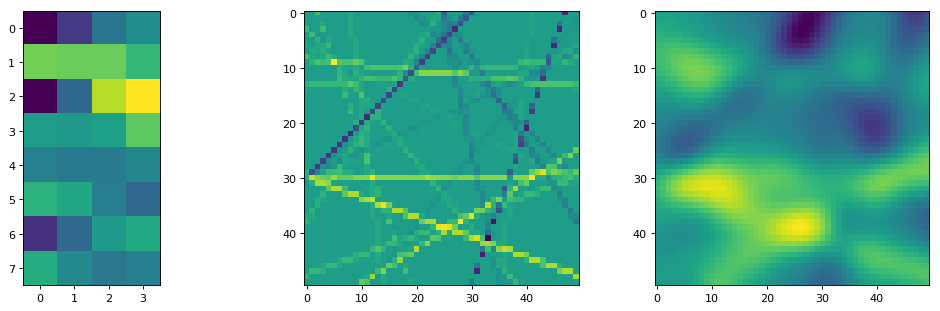

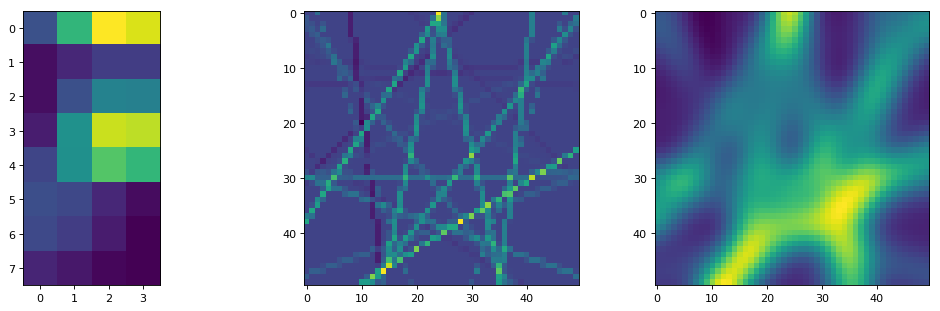

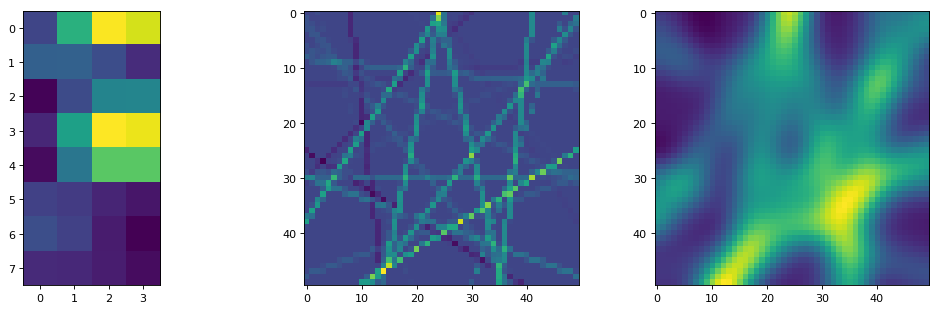

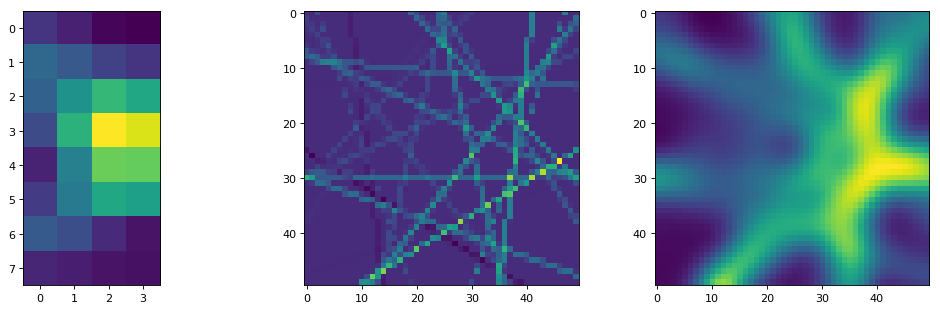

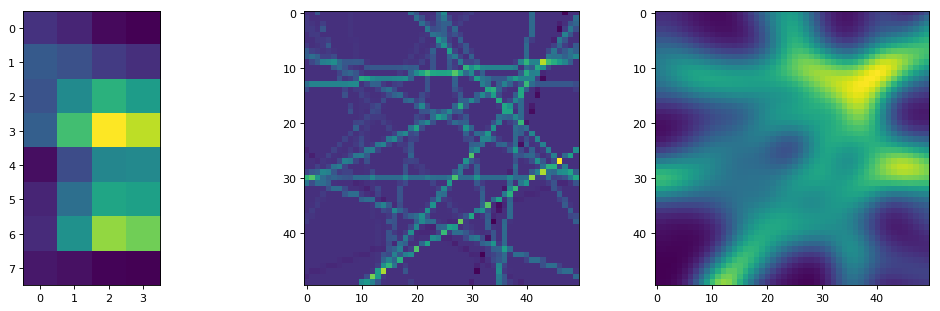

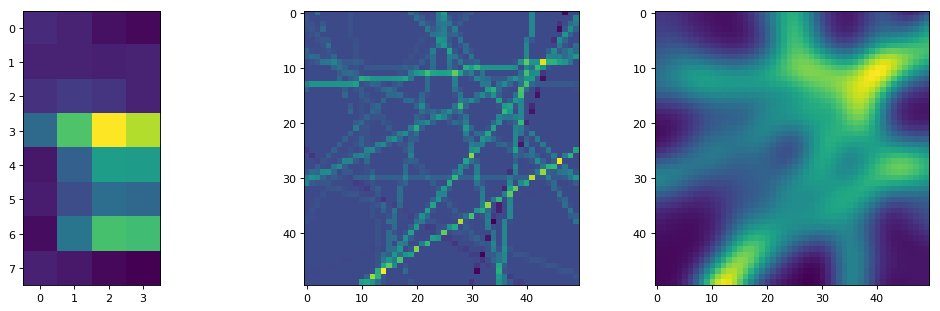

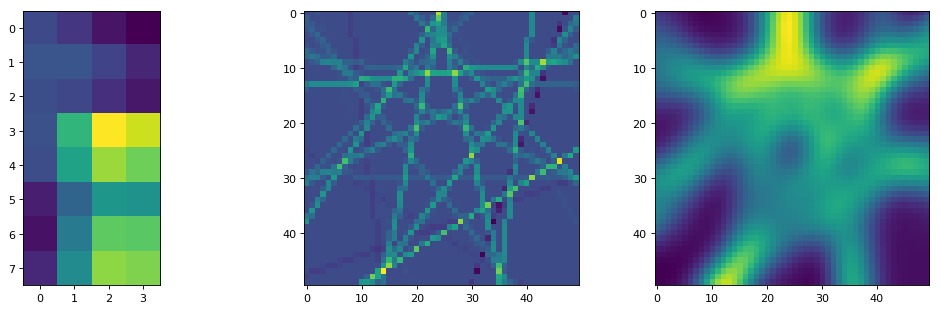

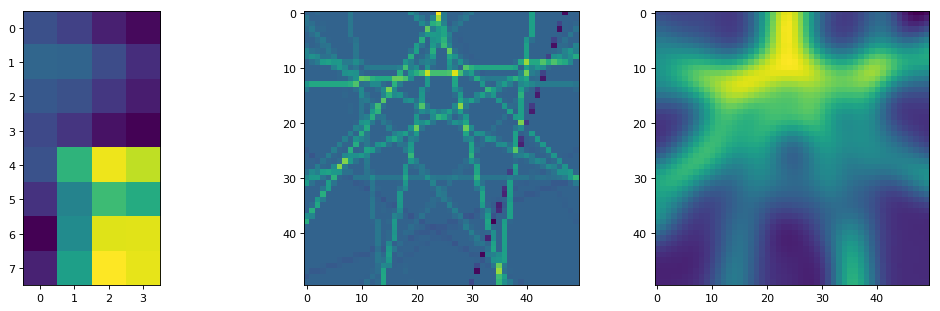

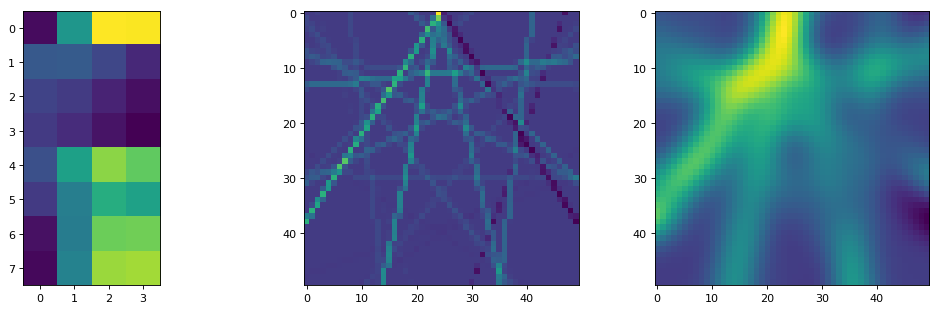

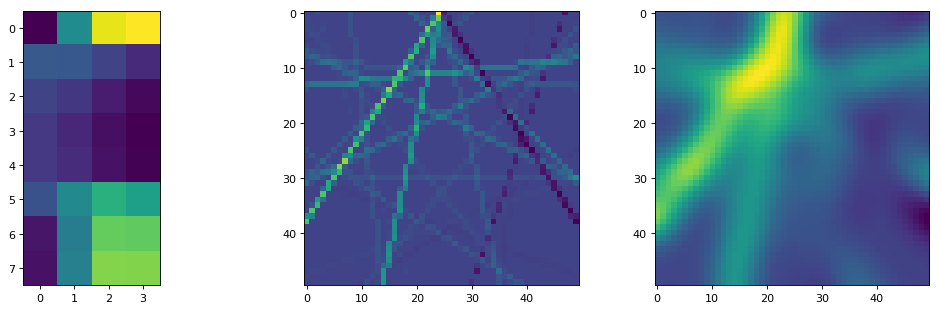

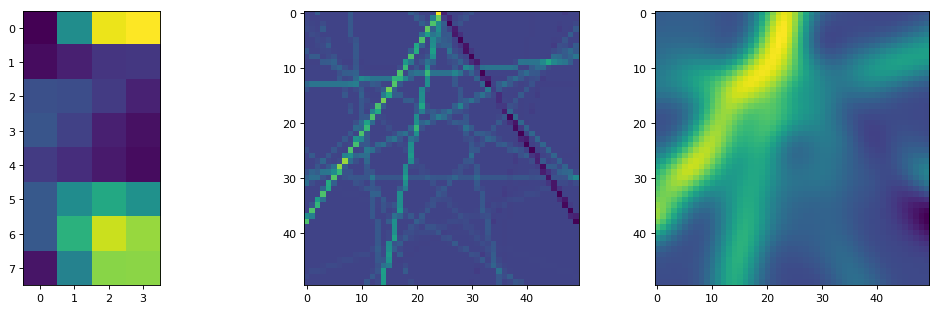

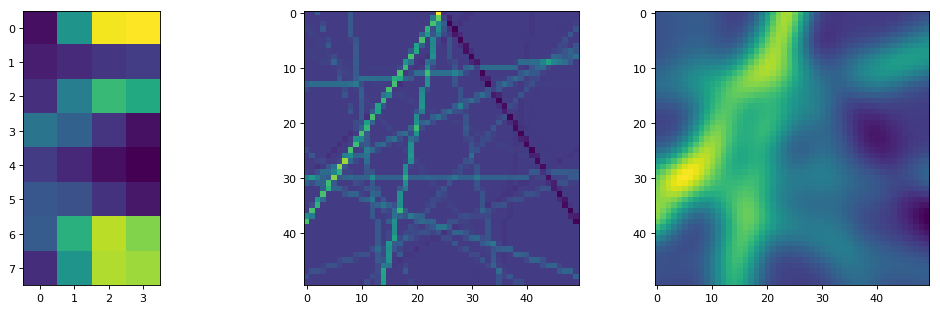

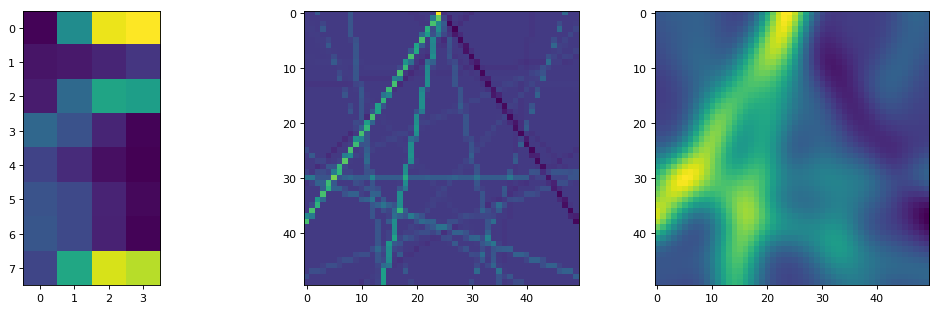

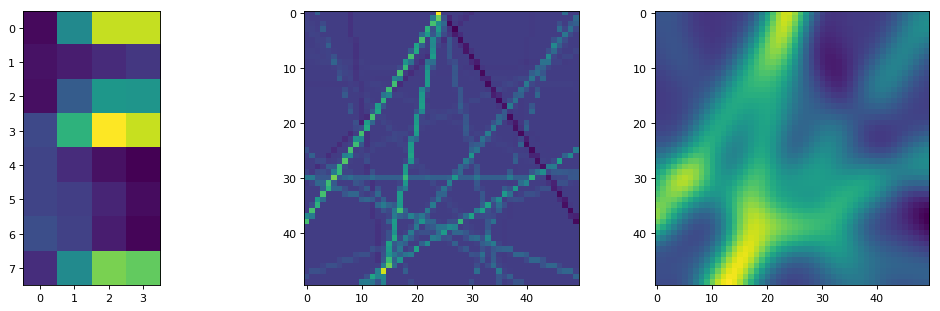

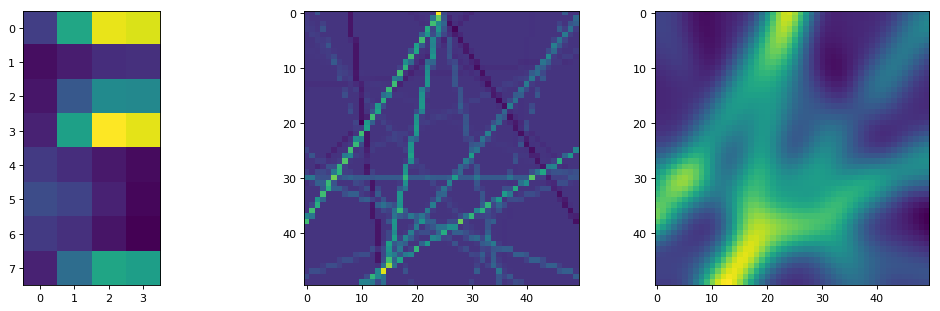

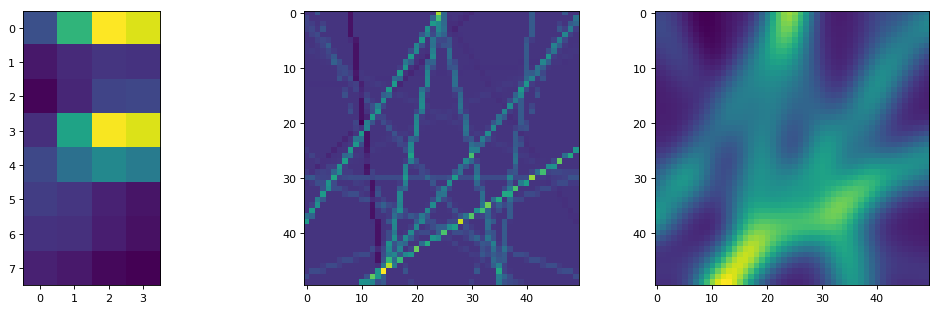

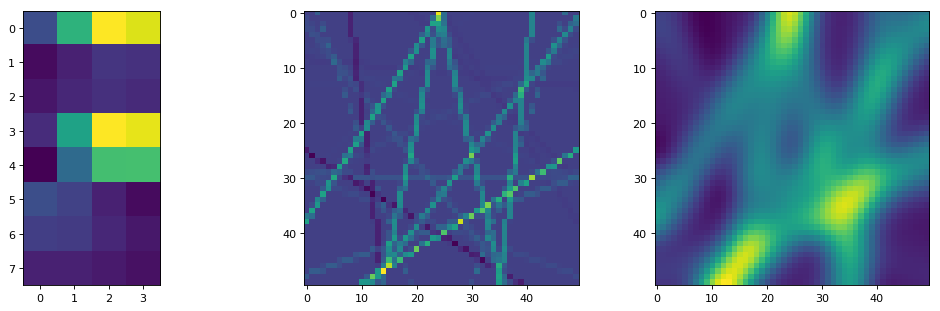

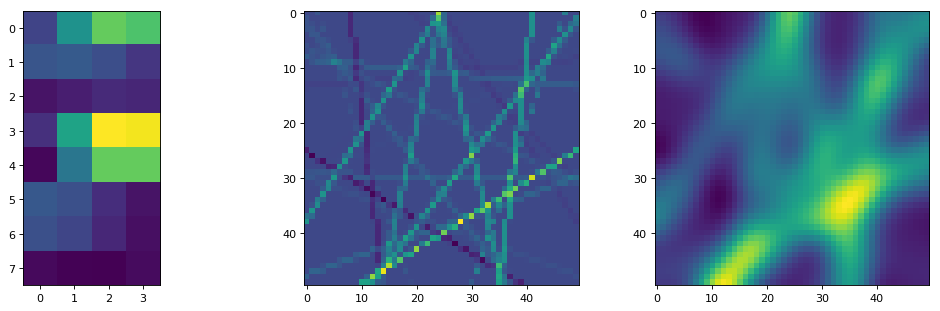

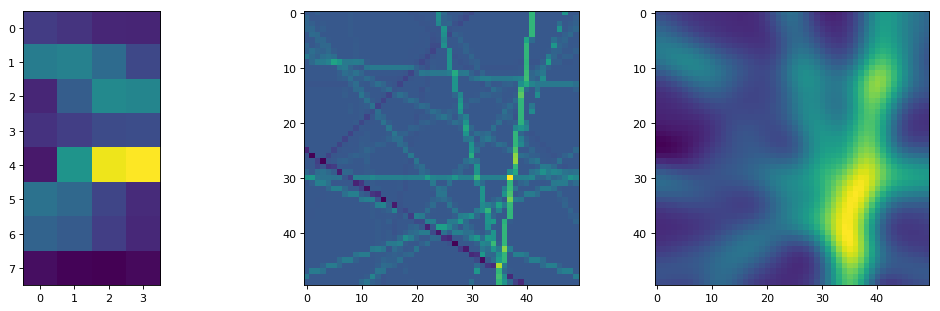

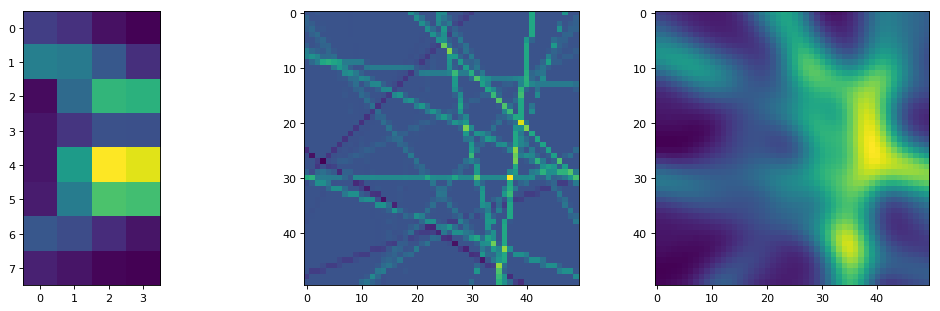

In [97]:
%%time
for i in range(20):
    print(i)
    readings = read_all()[8:] # Raw readings
    readings = [readings[i] - base[i] for i in range(len(base))] # - base
    readings = r8_to_sino(readings) # Get important ones and reorder
    
    readings2 = []
    for r in readings:
        f = interp1d(tau, r, kind='cubic') # Can change to linear
        readings2.append(f(tau_new))
        
    
    sinogram_id = astra.data2d.create('-sino', proj_geom, np.asarray(readings2))
    
    # Plotting sinogram - new (transformed) set of readings
    plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
    ax1 = plt.subplot(2, 3, 1)
    ax1.imshow(readings2) #<< Set title

    # Doing the reconstruction, in this case with FBP

    rec_id = astra.data2d.create('-vol', vol_geom)

    cfg = astra.astra_dict('FBP')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = proj_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    astra.algorithm.run(alg_id, 1)

    # Get the result
    rec = astra.data2d.get(rec_id)
    ax2 = plt.subplot(2, 3, 2)
    ax2.imshow(rec)
    norm_rec = rec/(np.amax(rec)*2)
    blurred = skimage.filters.gaussian(norm_rec, 3)
    ax3 = plt.subplot(2, 3, 3)
    ax3.imshow(blurred)
    
    plt.savefig(str(i) + '.png')



In [77]:
# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)